# Pre process codes

## import

In [1]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint



## trim and balance

In [2]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=os.listdir(classpath)    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 
   


## pre processing

In [3]:
from skimage import exposure
import cv2
import numpy as np

# Preprocessing functions
from skimage import exposure
import cv2


def histogram_equalization(image):
  """
  Applies histogram equalization to enhance contrast.
  Args:
    image: The grayscale image.
  Returns:
    The equalized image.
  """
  equalized_image = exposure.equalize_adapthist(image ,  clip_limit=0.01)
  return equalized_image

def preprocessing_function(image):
    """
    Preprocesses knee X-ray images for CNN training.

    Args:
        image: The RGB image.
        contrast_method: "histogram_equalization" or "clahe_contrast_enhancement" (default: "histogram_equalization").

    Returns:
        The preprocessed image.
    """

    enhanced_image = histogram_equalization(image.copy())
    print("Enhanced Image Shape:", enhanced_image.shape)
    return enhanced_image





Enhanced Image Shape: (224, 224, 3)


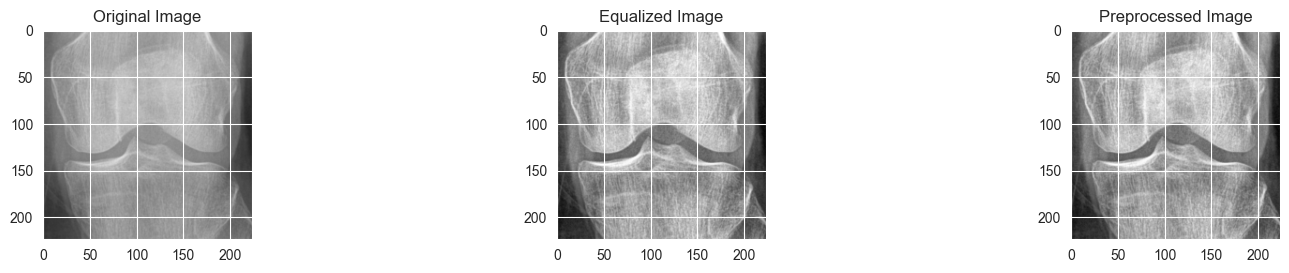

In [4]:
# Choose the desired contrast method
contrast_method = "histogram_equalization"  # Choose either "histogram_equalization" or "clahe_contrast_enhancement"

image = cv2.imread("F:\\music\\ex.PNG")

prep=preprocessing_function(image.copy())

# Apply ROI masking with Otsu's thresholding
# masked_image = otsu_thresholding_roi(image.copy())

# Apply histogram equalization
equalized_image = histogram_equalization(image.copy())

# Apply CLAHE contrast enhancement
# clahe_enhanced_image = clahe_contrast_enhancement(equalized_image)

# Visualize images at each step
# ...

# Visualize images at each step
plt.figure(figsize=(13, 6))

# Original Image
plt.subplot(1, 5, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

# Masked Image (After ROI masking with Otsu's thresholding)
# plt.subplot(1, 5, 2)
# plt.imshow(masked_image, cmap='gray')
# plt.title("Masked Image")

# Equalized Image (After histogram equalization)
plt.subplot(1, 5, 3)
plt.imshow(equalized_image, cmap='gray')
plt.title("Equalized Image")


# # CLAHE Enhanced Image
# plt.subplot(1, 5, 4)
# plt.imshow(clahe_enhanced_image, cmap='gray')
# plt.title("CLAHE Enhanced Image")

# preprocessed Enhanced Image
plt.subplot(1, 5, 5)
plt.imshow(prep, cmap='gray')
plt.title("Preprocessed Image")

plt.tight_layout()
plt.show()

# making dataframes

## make data frame

In [4]:
"D:\\Knee_data_Clahe\\cropped\\train"
IMGSZ= (224,224)
train_path="C:\\Users\\91745\\Documents\\Datasets\\knee\\train" 
test_path= "C:\\Users\\91745\\Documents\\Datasets\\knee\\test" 
valid_path="C:\\Users\\91745\\Documents\\Datasets\\knee\\val" 

# train_path="D:\\Knee_data_Clahe\\train" 
# test_path= "D:\\Knee_data_Clahe\\test" 
# valid_path= "D:\\Knee_data_Clahe\\val" 

# train_path="D:\\Knee_data_Clahe\\cropped\\train" 
# test_path= "D:\\Knee_data_Clahe\\cropped\\test" 
# valid_path= "D:\\Knee_data_Clahe\\cropped\\val" 

# train_path="D:\\cropped_knees\\train"
# test_path= "D:\\cropped_knees\\test" 
# valid_path="D:\\cropped_knees\\val" 



list_of_classes=['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']
for d in [train_path, test_path, valid_path]:
    filepaths = []
    labels=[] 
    classlist=os.listdir(d)   
    for klass in classlist:
        intklass=int(klass)
        label=list_of_classes[intklass]
        classpath=os.path.join(d, klass)
        flist=os.listdir(classpath)        
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(label)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')        
    pdf=pd.concat([Fseries, Lseries], axis=1)
    if d == test_path:
        test_df=pdf
    elif d == valid_path:
        valid_df=pdf
    else:
        train_df=pdf
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  5778   test_df length:  1656   valid_df length:  826
The number of classes in the dataset is:  5
            CLASS               IMAGE COUNT 
           Doubtful                1046     
           Healthy                 2286     
           Minimal                 1516     
           Moderate                 757     
            Severe                  173     
Healthy  has the most images=  2286   Severe  has the least images=  173
average height=  224  average width=  224 aspect ratio=  1.0


## drop

In [5]:
# Drop specified classes

drop_classes = ['Doubtful', 'Minimal', 'Moderate' ]

train_df = train_df[~train_df['labels'].isin(drop_classes)]
valid_df = valid_df[~valid_df['labels'].isin(drop_classes)]  
test_df = test_df[~test_df['labels'].isin(drop_classes)]

# Update the list of classes 
list_of_classes = [c for c in list_of_classes if c not in drop_classes]

# Re-calculate the total classes
class_count = len(list_of_classes)

# Re-count the images per class
groups = train_df.groupby('labels')  
for label in list_of_classes:
    group = groups.get_group(label) 
    print(label, len(group))

Healthy 2286
Severe 173


## trim them 

In [6]:
max_samples=500
# since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=173
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  173


In [7]:
n=500 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=IMGSZ # size of augmented images
train_df=balance(train_df, n, working_dir, img_size) 

Initial length of dataframe is  673
Found 173 validated image filenames.     for class             Severe             creating  327  augmented images 
Total Augmented images created=  327
Length of augmented dataframe is now  1000


In [8]:
print (train_df['labels'].value_counts())

Healthy    500
Severe     500
Name: labels, dtype: int64


## train gen 

In [9]:
# Data augmentation and generators
img_size = IMGSZ
batch_size = 32
trgen = ImageDataGenerator(horizontal_flip=True,rotation_range=20,
                            vertical_flip=0.3, shear_range=0.08,
                            zoom_range=0.1, brightness_range=[0.9, 1.1],
#                             contrast_range=[0.9, 1.1],fill_mode='nearest'
                            )

t_and_v_gen = ImageDataGenerator()

train_gen = trgen.flow_from_dataframe(
    train_df,
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
    preprocessing_function=preprocessing_function,
)

valid_gen = t_and_v_gen.flow_from_dataframe(
    valid_df,
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
    preprocessing_function=preprocessing_function,
)

# Calculate test steps
length = len(test_df)
test_batch_size = sorted(
    [
        int(length / n)
        for n in range(1, length + 1)
        if length % n == 0 and length / n <= 80
    ],
    reverse=True,
)[0]
test_steps = int(length / test_batch_size)

test_gen = t_and_v_gen.flow_from_dataframe(
    test_df,
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=False,
    batch_size=test_batch_size,
    preprocessing_function=preprocessing_function,
)

Found 1000 validated image filenames belonging to 2 classes.
Found 355 validated image filenames belonging to 2 classes.
Found 690 validated image filenames belonging to 2 classes.


# see the images 

## show images "

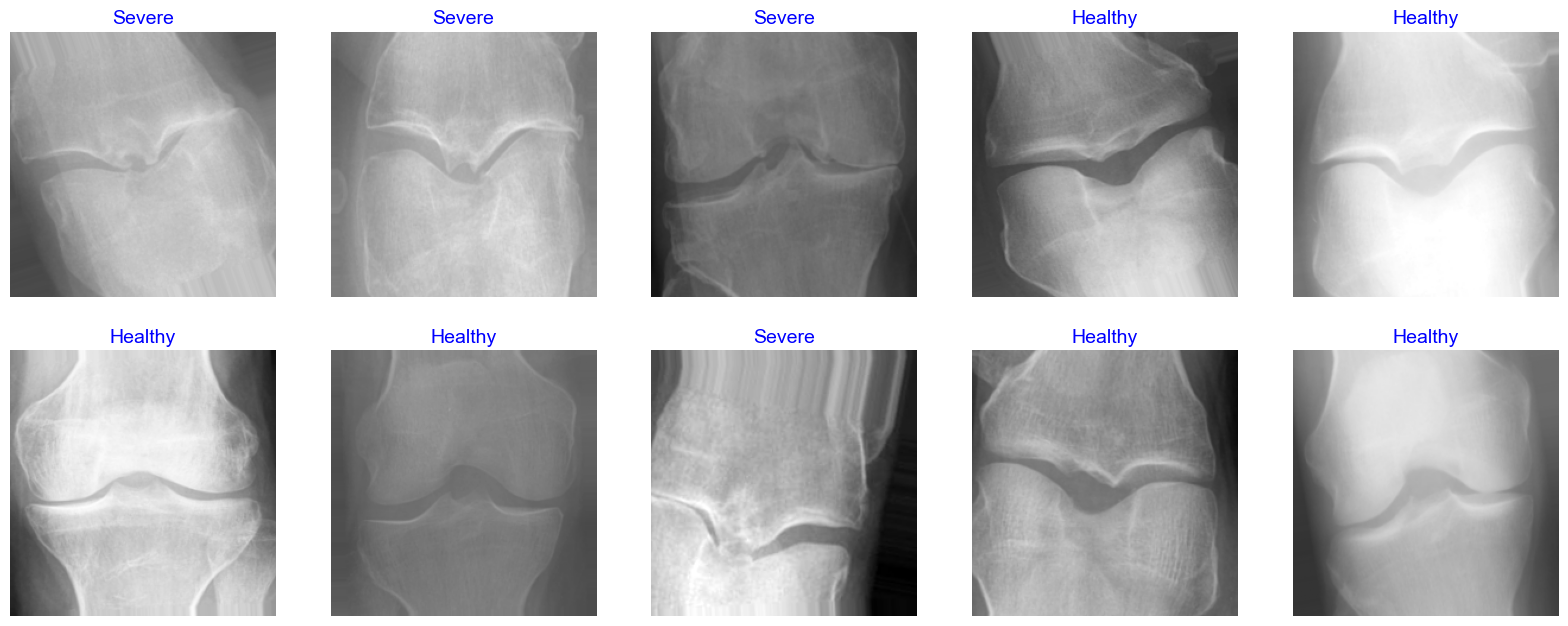

In [10]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())    
    images, labels = next(gen)  # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length = len(labels)
    
    if length < 10:  # show a maximum of 25 images
        r = length
    else:
        r = 10
    
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    
    plt.show()

# Visualize images without additional preprocessing
show_image_samples(train_gen)


# training

##  efficient net model

In [144]:
img_size[0]

224

In [145]:
img_size[1]

224

In [11]:
# Additional code for model definition, training, and evaluation should go here

# Model definition
from tensorflow.keras import layers

K.clear_session()  # Clear the session
tf.compat.v1.reset_default_graph()

img_shape = (img_size[0], img_size[1], 3)
model_name = "EfficientNetB5"
base_model = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top=False, weights="imagenet", input_shape=img_shape, pooling="max"
)

# Freeze most of the base model layers
base_model.trainable = False

# Fine-tune the last few layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(
    256,
    kernel_regularizer=regularizers.l2(l=0.016),
    activity_regularizer=regularizers.l1(0.006),
    bias_regularizer=regularizers.l1(0.006),
    activation="relu",
)(x)
x = Dropout(rate=0.4, seed=123)(x)
output = Dense(len(list_of_classes), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']      

 block1c_dwconv (DepthwiseConv2  (None, 112, 112, 24  216        ['block1b_add[0][0]']            
 D)                             )                                                                 
                                                                                                  
 block1c_bn (BatchNormalization  (None, 112, 112, 24  96         ['block1c_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block1c_activation (Activation  (None, 112, 112, 24  0          ['block1c_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block1c_se_squeeze (GlobalAver  (None, 24)          0           ['block1c_activation[0][0]']     
 agePoolin

 )                                                                                                
                                                                                                  
 block2b_activation (Activation  (None, 56, 56, 240)  0          ['block2b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2b_se_squeeze (GlobalAver  (None, 240)         0           ['block2b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2b_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block2b_se_squeeze[0][0]']     
                                                                                                  
 block2b_s

 block2d_se_squeeze (GlobalAver  (None, 240)         0           ['block2d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2d_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block2d_se_squeeze[0][0]']     
                                                                                                  
 block2d_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block2d_se_reshape[0][0]']     
                                                                                                  
 block2d_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block2d_se_reduce[0][0]']      
                                                                                                  
 block2d_se_excite (Multiply)   (None, 56, 56, 240)  0           ['block2d_activation[0][0]',     
          

                                                                                                  
 block3a_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block3a_se_squeeze[0][0]']     
                                                                                                  
 block3a_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block3a_se_reshape[0][0]']     
                                                                                                  
 block3a_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block3a_se_reduce[0][0]']      
                                                                                                  
 block3a_se_excite (Multiply)   (None, 28, 28, 240)  0           ['block3a_activation[0][0]',     
                                                                  'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_p

 block3c_project_conv (Conv2D)  (None, 28, 28, 64)   24576       ['block3c_se_excite[0][0]']      
                                                                                                  
 block3c_project_bn (BatchNorma  (None, 28, 28, 64)  256         ['block3c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3c_drop (Dropout)         (None, 28, 28, 64)   0           ['block3c_project_bn[0][0]']     
                                                                                                  
 block3c_add (Add)              (None, 28, 28, 64)   0           ['block3c_drop[0][0]',           
                                                                  'block3b_add[0][0]']            
                                                                                                  
 block3d_e

 block3e_drop (Dropout)         (None, 28, 28, 64)   0           ['block3e_project_bn[0][0]']     
                                                                                                  
 block3e_add (Add)              (None, 28, 28, 64)   0           ['block3e_drop[0][0]',           
                                                                  'block3d_add[0][0]']            
                                                                                                  
 block4a_expand_conv (Conv2D)   (None, 28, 28, 384)  24576       ['block3e_add[0][0]']            
                                                                                                  
 block4a_expand_bn (BatchNormal  (None, 28, 28, 384)  1536       ['block4a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4a_e

 block4c_expand_bn (BatchNormal  (None, 14, 14, 768)  3072       ['block4c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4c_expand_activation (Act  (None, 14, 14, 768)  0          ['block4c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4c_dwconv (DepthwiseConv2  (None, 14, 14, 768)  6912       ['block4c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4c_bn (BatchNormalization  (None, 14, 14, 768)  3072       ['block4c_dwconv[0][0]']         
 )        

                                                                                                  
 block4e_dwconv (DepthwiseConv2  (None, 14, 14, 768)  6912       ['block4e_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4e_bn (BatchNormalization  (None, 14, 14, 768)  3072       ['block4e_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4e_activation (Activation  (None, 14, 14, 768)  0          ['block4e_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4e_s

 )                                                                                                
                                                                                                  
 block4g_activation (Activation  (None, 14, 14, 768)  0          ['block4g_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4g_se_squeeze (GlobalAver  (None, 768)         0           ['block4g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4g_se_reshape (Reshape)   (None, 1, 1, 768)    0           ['block4g_se_squeeze[0][0]']     
                                                                                                  
 block4g_s

                                                                                                  
 block5b_se_reduce (Conv2D)     (None, 1, 1, 44)     46508       ['block5b_se_reshape[0][0]']     
                                                                                                  
 block5b_se_expand (Conv2D)     (None, 1, 1, 1056)   47520       ['block5b_se_reduce[0][0]']      
                                                                                                  
 block5b_se_excite (Multiply)   (None, 14, 14, 1056  0           ['block5b_activation[0][0]',     
                                )                                 'block5b_se_expand[0][0]']      
                                                                                                  
 block5b_project_conv (Conv2D)  (None, 14, 14, 176)  185856      ['block5b_se_excite[0][0]']      
                                                                                                  
 block5b_p

 block5d_se_expand (Conv2D)     (None, 1, 1, 1056)   47520       ['block5d_se_reduce[0][0]']      
                                                                                                  
 block5d_se_excite (Multiply)   (None, 14, 14, 1056  0           ['block5d_activation[0][0]',     
                                )                                 'block5d_se_expand[0][0]']      
                                                                                                  
 block5d_project_conv (Conv2D)  (None, 14, 14, 176)  185856      ['block5d_se_excite[0][0]']      
                                                                                                  
 block5d_project_bn (BatchNorma  (None, 14, 14, 176)  704        ['block5d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5d_d

                                )                                 'block5f_se_expand[0][0]']      
                                                                                                  
 block5f_project_conv (Conv2D)  (None, 14, 14, 176)  185856      ['block5f_se_excite[0][0]']      
                                                                                                  
 block5f_project_bn (BatchNorma  (None, 14, 14, 176)  704        ['block5f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5f_drop (Dropout)         (None, 14, 14, 176)  0           ['block5f_project_bn[0][0]']     
                                                                                                  
 block5f_add (Add)              (None, 14, 14, 176)  0           ['block5f_drop[0][0]',           
          

                                                                  'block6a_se_expand[0][0]']      
                                                                                                  
 block6a_project_conv (Conv2D)  (None, 7, 7, 304)    321024      ['block6a_se_excite[0][0]']      
                                                                                                  
 block6a_project_bn (BatchNorma  (None, 7, 7, 304)   1216        ['block6a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_expand_conv (Conv2D)   (None, 7, 7, 1824)   554496      ['block6a_project_bn[0][0]']     
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, 7, 7, 1824)  7296        ['block6b_expand_conv[0][0]']    
 ization) 

                                                                  'block6b_add[0][0]']            
                                                                                                  
 block6d_expand_conv (Conv2D)   (None, 7, 7, 1824)   554496      ['block6c_add[0][0]']            
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, 7, 7, 1824)  7296        ['block6d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6d_expand_activation (Act  (None, 7, 7, 1824)  0           ['block6d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6d_d

 ization)                                                                                         
                                                                                                  
 block6f_expand_activation (Act  (None, 7, 7, 1824)  0           ['block6f_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6f_dwconv (DepthwiseConv2  (None, 7, 7, 1824)  45600       ['block6f_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6f_bn (BatchNormalization  (None, 7, 7, 1824)  7296        ['block6f_dwconv[0][0]']         
 )                                                                                                
          

 block6h_dwconv (DepthwiseConv2  (None, 7, 7, 1824)  45600       ['block6h_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6h_bn (BatchNormalization  (None, 7, 7, 1824)  7296        ['block6h_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6h_activation (Activation  (None, 7, 7, 1824)  0           ['block6h_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6h_se_squeeze (GlobalAver  (None, 1824)        0           ['block6h_activation[0][0]']     
 agePoolin

                                                                                                  
 block7a_activation (Activation  (None, 7, 7, 1824)  0           ['block7a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block7a_se_squeeze (GlobalAver  (None, 1824)        0           ['block7a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 1824)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_se_reduce (Conv2D)     (None, 1, 1, 76)     138700      ['block7a_se_reshape[0][0]']     
          

                                                                                                  
 block7c_se_expand (Conv2D)     (None, 1, 1, 3072)   396288      ['block7c_se_reduce[0][0]']      
                                                                                                  
 block7c_se_excite (Multiply)   (None, 7, 7, 3072)   0           ['block7c_activation[0][0]',     
                                                                  'block7c_se_expand[0][0]']      
                                                                                                  
 block7c_project_conv (Conv2D)  (None, 7, 7, 512)    1572864     ['block7c_se_excite[0][0]']      
                                                                                                  
 block7c_project_bn (BatchNorma  (None, 7, 7, 512)   2048        ['block7c_project_conv[0][0]']   
 lization)                                                                                        
          

In [12]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_gen, steps=test_steps)

# Print the test accuracy
print("Test accuracy:", test_acc)

10/10 [==============================] - 21s 666ms/step - loss: 10.4106 - accuracy: 0.9203
Test accuracy: 0.9202898740768433


In [13]:
epochs=10
# ask_epoch=10
# ask=LR_ASK(model, epochs,  ask_epoch)
# callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, #callbacks=callbacks,  
                  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Epoch 1/10
32/32 [==============================] - 38s 676ms/step - loss: 7.5869 - accuracy: 0.8620 - val_loss: 7.1362 - val_accuracy: 0.9437
Epoch 2/10
32/32 [==============================] - 16s 488ms/step - loss: 5.7934 - accuracy: 0.9270 - val_loss: 5.6676 - val_accuracy: 0.9521
Epoch 3/10
32/32 [==============================] - 16s 492ms/step - loss: 4.8310 - accuracy: 0.9220 - val_loss: 4.5908 - val_accuracy: 0.9465
Epoch 4/10
32/32 [==============================] - 16s 485ms/step - loss: 4.0985 - accuracy: 0.9490 - val_loss: 3.8983 - val_accuracy: 0.9549
Epoch 5/10
32/32 [==============================] - 16s 484ms/step - loss: 3.5637 - accuracy: 0.9620 - val_loss: 3.3461 - val_accuracy: 0.9746
Epoch 6/10
32/32 [==============================] - 16s 489ms/step - loss: 3.1539 - accuracy: 0.9560 - val_loss: 2.9335 - val_accuracy: 0.9803
Epoch 7/10
32/32 [==============================] - 16s 506ms/step - loss: 2.7936 - accuracy: 0.9620 - val_loss: 2.6144 - val_accuracy: 0.9803

# post training

## testing

10/10 [==============================] - 18s 2s/step
there were 12 errors in 690 tests for an accuracy of  98.26


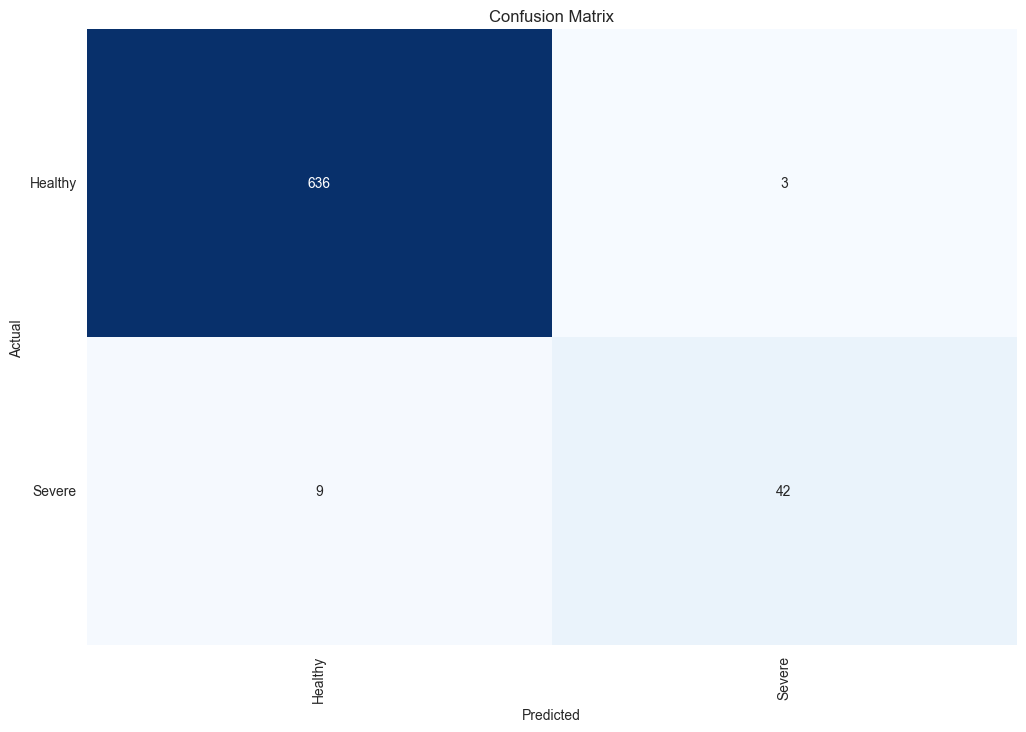

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.9860    0.9953    0.9907       639
      Severe     0.9333    0.8235    0.8750        51

    accuracy                         0.9826       690
   macro avg     0.9597    0.9094    0.9328       690
weighted avg     0.9822    0.9826    0.9821       690



In [14]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
            file=test_gen.filenames[i]
        y_pred.append(pred_index)

    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)


In [16]:


history=model.fit(x=train_gen,  epochs=20, verbose=1, #callbacks=callbacks,  
                  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=9)

Epoch 10/20
32/32 [==============================] - 42s 1s/step - loss: 1.8257 - accuracy: 0.9750 - val_loss: 1.7371 - val_accuracy: 0.9803
Epoch 11/20
32/32 [==============================] - 43s 1s/step - loss: 1.6717 - accuracy: 0.9730 - val_loss: 1.5900 - val_accuracy: 0.9803
Epoch 12/20
32/32 [==============================] - 34s 1s/step - loss: 1.5287 - accuracy: 0.9750 - val_loss: 1.4202 - val_accuracy: 0.9831
Epoch 13/20
32/32 [==============================] - 16s 495ms/step - loss: 1.3958 - accuracy: 0.9710 - val_loss: 1.3082 - val_accuracy: 0.9831
Epoch 14/20
23/32 [====================>.........] - ETA: 3s - loss: 1.3163 - accuracy: 0.9769

UnknownError: Graph execution error:

2 root error(s) found.
  (0) UNKNOWN:  FileNotFoundError: [Errno 2] No such file or directory: './aug\\Severe\\aug-_48_2643592.jpg'
Traceback (most recent call last):

  File "D:\00Installation\Anaconda\envs\tensorfloww\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "D:\00Installation\Anaconda\envs\tensorfloww\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "D:\00Installation\Anaconda\envs\tensorfloww\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1035, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "D:\00Installation\Anaconda\envs\tensorfloww\lib\site-packages\keras\engine\data_adapter.py", line 903, in wrapped_generator
    for data in generator_fn():

  File "D:\00Installation\Anaconda\envs\tensorfloww\lib\site-packages\keras\engine\data_adapter.py", line 1050, in generator_fn
    yield x[i]

  File "D:\00Installation\Anaconda\envs\tensorfloww\lib\site-packages\keras\preprocessing\image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "D:\00Installation\Anaconda\envs\tensorfloww\lib\site-packages\keras\preprocessing\image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "D:\00Installation\Anaconda\envs\tensorfloww\lib\site-packages\keras\utils\image_utils.py", line 422, in load_img
    with open(path, "rb") as f:

FileNotFoundError: [Errno 2] No such file or directory: './aug\\Severe\\aug-_48_2643592.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[categorical_crossentropy/softmax_cross_entropy_with_logits/Shape_2/_6]]
  (1) UNKNOWN:  FileNotFoundError: [Errno 2] No such file or directory: './aug\\Severe\\aug-_48_2643592.jpg'
Traceback (most recent call last):

  File "D:\00Installation\Anaconda\envs\tensorfloww\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "D:\00Installation\Anaconda\envs\tensorfloww\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "D:\00Installation\Anaconda\envs\tensorfloww\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1035, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "D:\00Installation\Anaconda\envs\tensorfloww\lib\site-packages\keras\engine\data_adapter.py", line 903, in wrapped_generator
    for data in generator_fn():

  File "D:\00Installation\Anaconda\envs\tensorfloww\lib\site-packages\keras\engine\data_adapter.py", line 1050, in generator_fn
    yield x[i]

  File "D:\00Installation\Anaconda\envs\tensorfloww\lib\site-packages\keras\preprocessing\image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "D:\00Installation\Anaconda\envs\tensorfloww\lib\site-packages\keras\preprocessing\image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "D:\00Installation\Anaconda\envs\tensorfloww\lib\site-packages\keras\utils\image_utils.py", line 422, in load_img
    with open(path, "rb") as f:

FileNotFoundError: [Errno 2] No such file or directory: './aug\\Severe\\aug-_48_2643592.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_41529]

In [ ]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
            file=test_gen.filenames[i]
        y_pred.append(pred_index)

    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)


## graph 

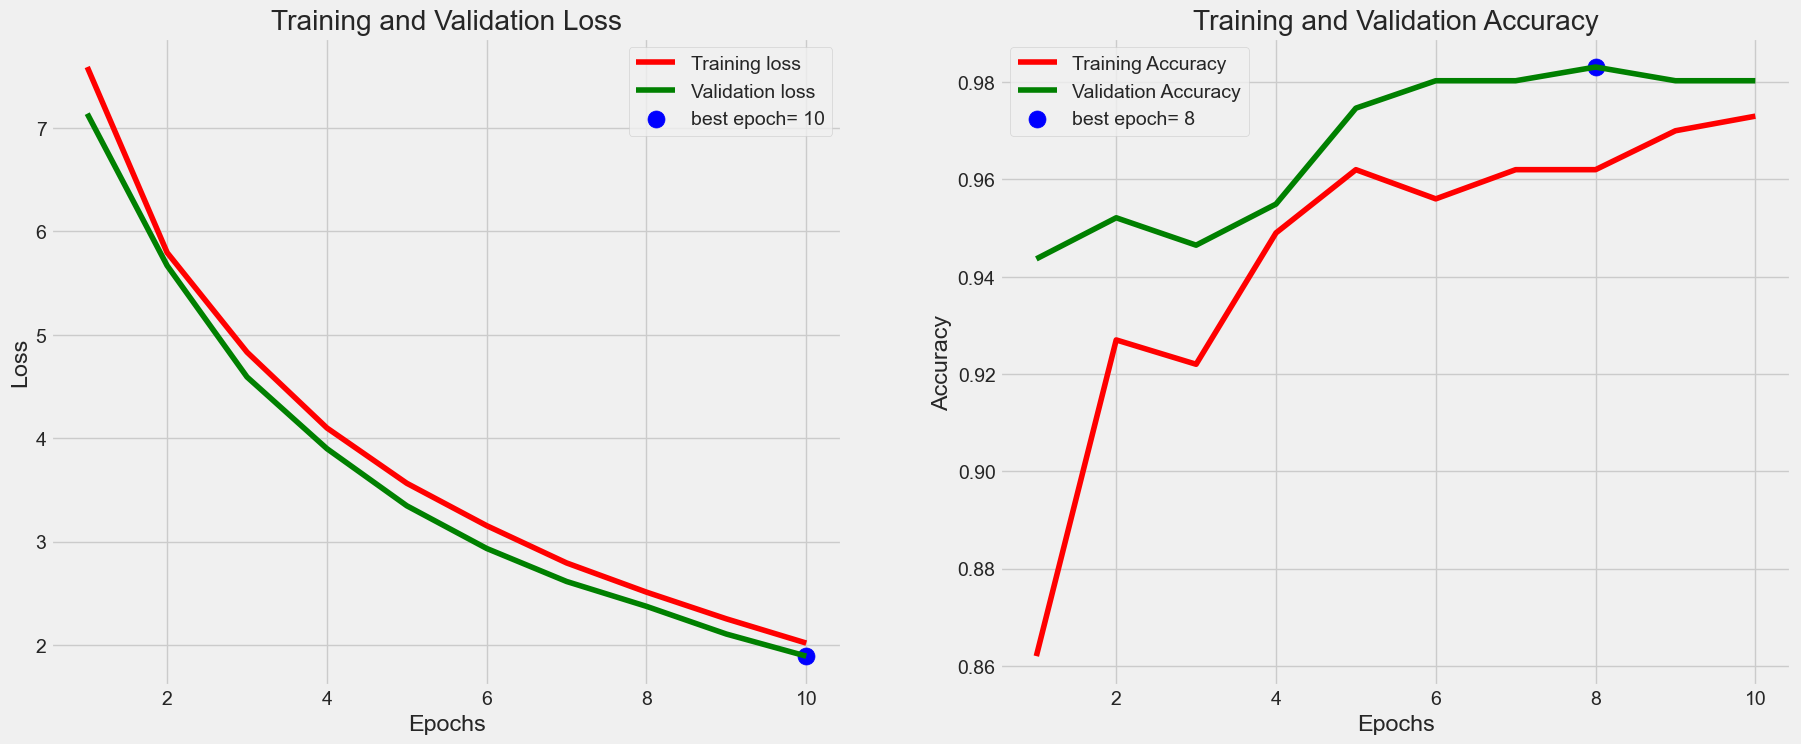

In [15]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)


# end

In [123]:
print (test_df['labels'].value_counts())

Healthy     639
Minimal     447
Doubtful    296
Moderate    223
Severe       51
Name: labels, dtype: int64


In [124]:
max_samples=51
# since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=51
column='labels'
test_df= trim(test_df, max_samples, min_samples, column)


n=52 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=IMGSZ # size of augmented images
test_df=balance(test_df, n, working_dir, img_size) 

print("")
print (test_df['labels'].value_counts())




t_and_v_gen = ImageDataGenerator()
test_gen = t_and_v_gen.flow_from_dataframe(
    test_df,
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=False,
    batch_size=test_batch_size,
    preprocessing_function=preprocessing_function,
)

after trimming, the maximum samples in any class is now  51  and the minimum samples in any class is  51
Initial length of dataframe is  255
Found 51 validated image filenames.      for class            Healthy             creating   1   augmented images 
Found 51 validated image filenames.      for class            Doubtful            creating   1   augmented images 
Found 51 validated image filenames.      for class            Minimal             creating   1   augmented images 
Found 51 validated image filenames.      for class            Moderate            creating   1   augmented images 
Found 51 validated image filenames.      for class             Severe             creating   1   augmented images 
Total Augmented images created=  5
Length of augmented dataframe is now  260

Healthy     52
Doubtful    52
Minimal     52
Moderate    52
Severe      52
Name: labels, dtype: int64
Found 260 validated image filenames belonging to 5 classes.


## balanced testing

4/4 [==============================] - 4s 1s/step
there were 133 errors in 260 tests for an accuracy of  48.85


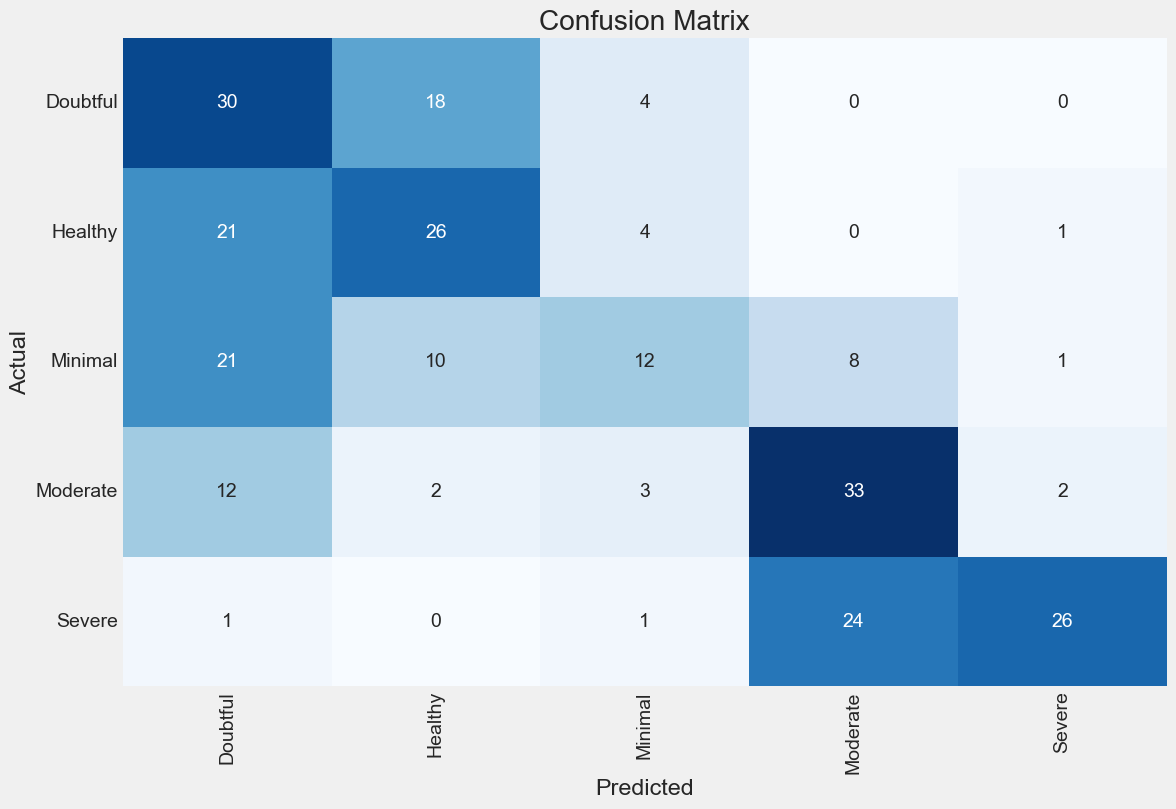

Classification Report:
----------------------
               precision    recall  f1-score   support

    Doubtful     0.3529    0.5769    0.4380        52
     Healthy     0.4643    0.5000    0.4815        52
     Minimal     0.5000    0.2308    0.3158        52
    Moderate     0.5077    0.6346    0.5641        52
      Severe     0.8667    0.5000    0.6341        52

    accuracy                         0.4885       260
   macro avg     0.5383    0.4885    0.4867       260
weighted avg     0.5383    0.4885    0.4867       260



In [125]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
            file=test_gen.filenames[i]
        y_pred.append(pred_index)

    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)
